# im2latex: Data Binning

&copy; Copyright 2017 Sumeet S Singh

    This file is part of im2latex solution by Sumeet S Singh.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the Affero GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    Affero GNU General Public License for more details.

    You should have received a copy of the Affero GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

# What This Program Does
This notebook curates the [im2latex-100k dataset from Harvard NLP](https://zenodo.org/record/56198#.WT4fsxMrJE4) from a [Harvard NLP project](http://lstm.seas.harvard.edu/latex/) generated using [their code]( https://github.com/Miffyli/im2latex-dataset).

* This notebook loads the data set which are png files generated using [textogif](https://www.fourmilab.ch/webtools/textogif/textogif.html) (via the abovementioned sourcecode)
* Checks and visualizes the data
* Curates the data - whitening etc.
* Converts it to numpy arrays and finally stores it as pickle files.

----
## 'Binning' Training Data by Markup Sequence Length
Next, we'll group the samples by length of the (tokenized) latex formulas. The idea is to standardize the sequence lengths to a small set of fixed lengths (by padding smaller neighboring sequences with a 'null' tokens at the end.). This will allow us to create equal length batches for RNN/LSTM training while minimizing wasted training cycles. The [Show, Attend and Tell paper](https://www.semanticscholar.org/paper/Show-Attend-and-Tell-Neural-Image-Caption-Generati-Xu-Ba/146f6f6ed688c905fb6e346ad02332efd5464616) suggests this approach. At every epoch, we'll randomly/uniformly draw batches from within each group. Then we'll randomize said batch-list and use it for the training epoch. At next epoch, we'll repeat the process. The larger our group-size, that much better randomness we'll get in the training sequence. However the downside of increasing group-size is more padding of sequence-lengths resulting in wasteful  (and worse; maybe even misleading) training cycles.

-----

In [7]:
from __future__ import print_function
import os
import numpy as np
from IPython.display import display, Image as ipImage
import PIL
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [8]:
# pd.options.display.max_rows = 600
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
pd.options.display.width = 160

### Notebook Arguments
Change the arguments below before you run the notebook.

In [9]:
HYPER_batch_size = 56
HYPER_bins=[0,30,40,50,60,70,80,90,110,150]
# HYPER_bins = [0,150]
data_folder = data_dir = '../data/dataset4'
image_folder = image_dir = os.path.join(data_folder, 'formula_images')
output_data_dir = os.path.join(data_folder, 'step4')
dump = False

In [10]:
df_pruned = pd.read_pickle(os.path.join(data_folder, 'step3', 'df_pruned.pkl'))
df_pruned.shape

(93741, 10)

In [11]:
df_pruned[['width', 'word2id_len', 'height']].corr()

,width,word2id_len,height
width,1.000000,0.818235,0.224680
word2id_len,0.818235,1.000000,0.409761
height,0.224680,0.409761,1.000000


From the above correlation table we can clearly see the impact of pruning the outlier samples from our dataset: the correlation of word2id_len went up from ~0.72 (for dff_all) to ~0.82 (for df_pruned).

In [12]:
df_pruned[['height','width']]

,height,width
0,78,738
1,94,962
2,87,291
3,35,405
4,60,521
5,102,206
7,31,282
8,80,817
9,35,296
10,75,697


In [13]:
display(df_pruned.word2id_len.quantile((.85,.90,.95,.96,.97,.98,.985,.99,1.0)))

0.850     91.0
0.900    101.0
0.950    116.0
0.960    120.0
0.970    125.0
0.980    131.0
0.985    135.0
0.990    139.0
1.000    150.0
Name: word2id_len, dtype: float64

**Below is what the sequence length distribution looks like at this point**

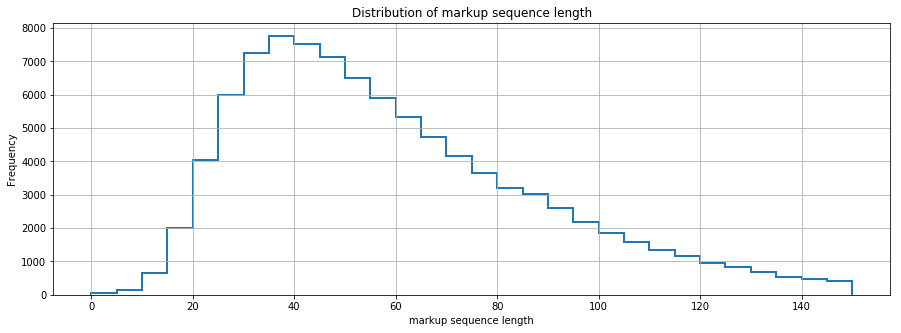

In [14]:
axes = plt.axes()
axes.set_xlabel('markup sequence length')
axes.set_title('Distribution of markup sequence length')
bins=range(0,151,5)
# df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=bins, xticks=bins, yticks=range(0,9001,1000))
df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=bins)

### Binning
Below we create the data-bins as described at the beginning of this section.

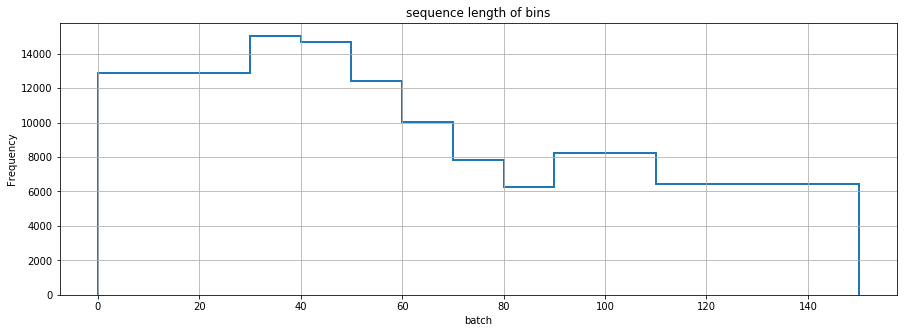

In [15]:
axes = plt.axes()
axes.set_xlabel('batch')
axes.set_ylabel('batch-count')
axes.set_title('sequence length of bins')
df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=HYPER_bins)

In [16]:
# 'bin' the entries
bin_lens=np.array(HYPER_bins[1:]) + 1 #Add 1 for ensuring minimum one 'null' token at the end of sequence.
# mapper for converting pandas category# into integer bin_len (because pandas Category are special types)
m = {i:bin_lens[i] for i in range(len(bin_lens))}

cats = pd.cut(df_pruned.word2id_len, HYPER_bins, labels=False)
df_bins = df_pruned.assign(bin_len=cats.map(m))[['image', 'height', 'width', 'word2id_len', 'bin_len',
                                                 'word2id', 'latex_ascii' ]]
df_bins.head()

,image,height,width,word2id_len,bin_len,word2id,latex_ascii
0,23be72ded29e9b4_basic.png,78,738,112,151,"[173, 324, 353, 11, 154, 355, 323, 353, 172, 355, 330, 338, 63, 207, 353, 331, 355, 323, 353, 11...",\int _ { - \epsilon } ^ { \infty } d l \: \mathrm { e } ^ { - l \zeta } \int _ { - \epsilon } ^ ...
1,8c904c5d9c7bd63_basic.png,94,962,129,151,"[330, 345, 323, 353, 18, 355, 29, 6, 17, 11, 353, 160, 353, 343, 328, 341, 345, 289, 355, 353, 3...",d s ^ { 2 } = ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } ...
2,1f111caa1be3516_basic.png,87,291,51,61,"[315, 161, 324, 353, 207, 353, 334, 341, 342, 332, 355, 355, 272, 283, 324, 353, 340, 30, 16, 35...",\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \...
3,76287b1b483a0d2_basic.png,35,405,43,51,"[6, 353, 125, 42, 355, 324, 353, 326, 355, 333, 7, 324, 353, 335, 336, 355, 29, 16, 10, 58, 58, ...","( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 ,"
4,7483d06c1e14dcb_basic.png,60,521,61,71,"[49, 324, 353, 345, 346, 326, 346, 355, 29, 18, 238, 277, 353, 44, 324, 353, 21, 355, 323, 353, ...",S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ( 1 ) } N _ { 5 } ^ { ( 2 ) } N _ { 5 } ^ { ( 3 ) ...


In [17]:
df_bins.groupby('bin_len').count()

,image,height,width,word2id_len,word2id,latex_ascii
bin_len,,,,,,
31,14277,14277,14277,14277,14277,14277
41,15162,15162,15162,15162,15162,15162
51,14472,14472,14472,14472,14472,14472
61,12179,12179,12179,12179,12179,12179
71,9815,9815,9815,9815,9815,9815
81,7612,7612,7612,7612,7612,7612
91,6129,6129,6129,6129,6129,6129
111,7966,7966,7966,7966,7966,7966
151,6129,6129,6129,6129,6129,6129


In [21]:
# randomly pick test-data - approx 10% of data size - ensuring it is an integral multiple of batch_size
frac = 0.1
test_count = int(df_bins.shape[0]*frac // HYPER_batch_size) * HYPER_batch_size
df_test = df_bins.sample(n=test_count)
df_train = df_bins.drop(df_test.index)
df_valid = df_train.sample(n=test_count)
df_train = df_train.drop(df_valid.index)
print(df_train.shape, df_valid.shape, df_test.shape)

(75037, 7) (9352, 7) (9352, 7)


### Persist

In [ ]:
if dump:
    if not os.path.exists(output_data_dir):
        os.makedirs(output_data_dir)
    df_train.to_pickle(os.path.join(output_data_dir, 'df_train.pkl'))
    df_test.to_pickle(os.path.join(output_data_dir, 'df_test.pkl'))
    df_valid.to_pickle(os.path.join(output_data_dir, 'df_valid.pkl'))


# END